<a href="https://colab.research.google.com/github/AbdillahM/Analisis-Sentimen-BERT-/blob/main/multilingual_BERT_Indonesian_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **1. Cek resource**

In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
!pip install transformers

## **2. Download & load dataset**

In [ ]:
from google.colab import drive
import pandas as pd


drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
data = '/content/drive/MyDrive/Colab Notebooks/skripsi/dataskripsifix.csv'

df = pd.read_csv(data)
df.shape

(4196, 2)

In [ ]:
sentences = df.text.values
labels = df.sentimen.values

## **3. Load BERT Tokenizer**

In [ ]:
from transformers import BertTokenizer

print("Loading BERT Tokenizer")
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

Loading BERT Tokenizer


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
df.sample(5)

,text,sentimen
2716,gabungan ani dan cak imin memang juara sayangn...,2
3091,tampak ani baswedan tiba dengan mengendarai mo...,0
4018,calon presiden nya siapa knk suka sekali bohong,2
358,sebagai sosok yg dekat dgn tradisi pesantren c...,0
2605,via ani tahun di dki jakarta apa yg mafaat bua...,2


In [ ]:
print("Original: ", sentences[0])

print("Tokenized: ", tokenizer.tokenize(sentences[0]))

print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  yuk kita semarakan pemilu dgn damai riang gembira tanpa ada cacian dan fitnah
Tokenized:  ['yu', '##k', 'kita', 'sem', '##arak', '##an', 'pe', '##mil', '##u', 'd', '##gn', 'dama', '##i', 'ria', '##ng', 'gem', '##bira', 'tanpa', 'ada', 'cac', '##ian', 'dan', 'fit', '##nah']
Token IDS:  [16566, 10167, 26917, 11664, 48435, 10208, 11178, 72878, 10136, 146, 22525, 36616, 10116, 50584, 10422, 51283, 68296, 27926, 14123, 10788, 11767, 10214, 20599, 44262]


In [ ]:
input_ids = []

for sent in sentences:
  encoded_sent = tokenizer.encode(
      sent,
      add_special_tokens = True
  )
  input_ids.append(encoded_sent)

print("Original: ", sentences[0])
print("Token IDs: ", input_ids[0])



Original:  yuk kita semarakan pemilu dgn damai riang gembira tanpa ada cacian dan fitnah
Token IDs:  [101, 16566, 10167, 26917, 11664, 48435, 10208, 11178, 72878, 10136, 146, 22525, 36616, 10116, 50584, 10422, 51283, 68296, 27926, 14123, 10788, 11767, 10214, 20599, 44262, 102]


In [ ]:
print("Max sentence length: ", max([len(sen) for sen in input_ids]))

Max sentence length:  92


In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 94
print("Padding/truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/truncating all sentences to 94 values
Padding token: "[PAD]", ID: 0
Done


In [ ]:
input_ids[0]

array([  101, 16566, 10167, 26917, 11664, 48435, 10208, 11178, 72878,
       10136,   146, 22525, 36616, 10116, 50584, 10422, 51283, 68296,
       27926, 14123, 10788, 11767, 10214, 20599, 44262,   102,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0])

In [ ]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent]

  attention_mask.append(att_mask)

## **4. Persiapkan data**

In [ ]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_labels, test_labels = train_test_split(input_ids,
                                                                      labels,
                                                                      random_state=2017,
                                                                      test_size=0.3)
train_mask, test_mask, _, _ = train_test_split(attention_mask,
                                               labels,
                                               random_state=2017,
                                               test_size=0.3)

train_input, validation_input, train_labels, validation_labels = train_test_split(train_input,
                                                                                  train_labels,
                                                                                  random_state=2018,
                                                                                  test_size=0.15)
train_mask, validation_mask, _, _ = train_test_split(train_mask,
                                                     train_mask,
                                                     random_state=2018,
                                                     test_size=0.15)

In [ ]:
import numpy as np
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  (2496, 94)
Label:  (2496,)
Mask:  (2496, 94)

== Validation ==
Input:  (441, 94)
Label:  (441,)
Mask:  (441, 94)

== Test ==
Input:  (1259, 94)
Label:  (1259,)
Mask:  (1259, 94)


In [ ]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## **5. Persiapkan model pre-trained BERT**

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False
)


model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.
==== Embedding Layer ====
bert.embeddings.word_embeddings.weight                       (105879, 768)
bert.embeddings.position_embeddings.weight                     (512, 768)
bert.embeddings.token_type_embeddings.weight                     (2, 768)
bert.embeddings.LayerNorm.weight                                   (768,)
bert.embeddings.LayerNorm.bias                                     (768,)
==== First Transformers ====
bert.encoder.layer.0.attention.self.query.weight               (768, 768)
bert.encoder.layer.0.attention.self.query.bias                     (768,)
bert.encoder.layer.0.attention.self.key.weight                 (768, 768)
bert.encoder.layer.0.attention.self.key.bias                       (768,)
bert.encoder.layer.0.attention.self.value.weight               (768, 768)
bert.encoder.layer.0.attention.self.value.bias                     (768,)
bert.encoder.layer.0.attention.output.dense.weight             (768, 768)
bert.

In [ ]:
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 8

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                             num_warmup_steps = 0,
                                             num_training_steps = total_steps)

In [ ]:
import numpy as np

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

## **6. Training BERT**

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time()

  total_loss = 0

  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):

    # Progress update every 40 batches
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

    loss = outputs[0]

    total_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)

  loss_values.append(avg_train_loss)

  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

  # ===================================
  #             Validation
  # ===================================

  print("Running Validation...")

  t0 = time.time()

  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1

  print("   Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("   Validation took: {:}".format(format_time(time.time() - t0)))

print("Training complete!")

======= Epoch 1 / 8 =======
Training...
Batch    40 of    78.     Elapsed: 0:00:22
   Average training loss: 0.92
   Training epoch took: 0:00:43
Running Validation...
   Accuracy: 0.63
   Validation took: 0:00:03
======= Epoch 2 / 8 =======
Training...
Batch    40 of    78.     Elapsed: 0:00:21
   Average training loss: 0.77
   Training epoch took: 0:00:41
Running Validation...
   Accuracy: 0.63
   Validation took: 0:00:03
======= Epoch 3 / 8 =======
Training...
Batch    40 of    78.     Elapsed: 0:00:21
   Average training loss: 0.63
   Training epoch took: 0:00:42
Running Validation...
   Accuracy: 0.66
   Validation took: 0:00:03
======= Epoch 4 / 8 =======
Training...
Batch    40 of    78.     Elapsed: 0:00:21
   Average training loss: 0.50
   Training epoch took: 0:00:41
Running Validation...
   Accuracy: 0.63
   Validation took: 0:00:03
======= Epoch 5 / 8 =======
Training...
Batch    40 of    78.     Elapsed: 0:00:21
   Average training loss: 0.40
   Training epoch took: 0:00:4

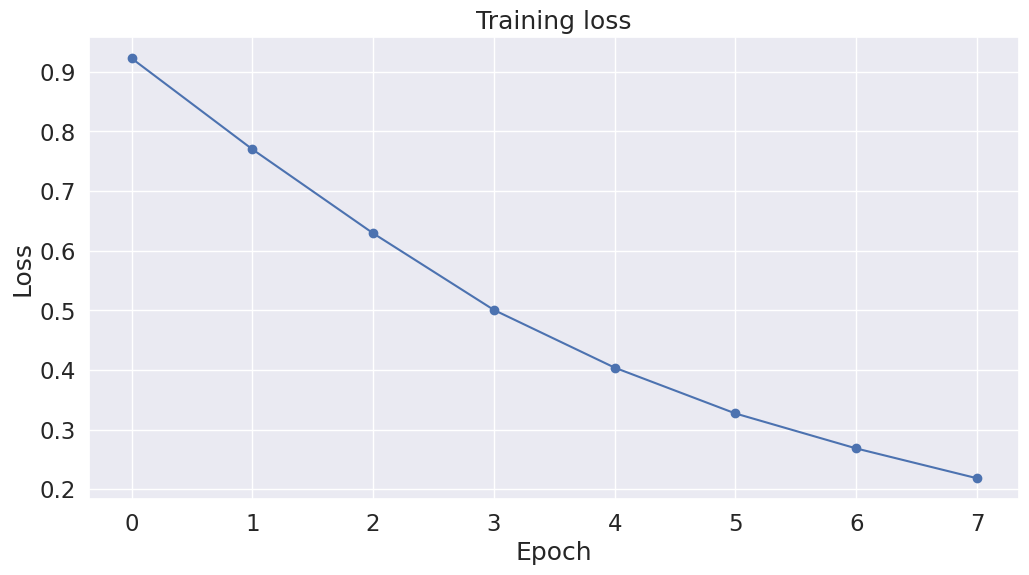

In [ ]:
import matplotlib.pyplot as plt


import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## **7. Predict dan Evaluate**

In [ ]:
print("Predicting labels for {:,} test sentences".format(len(test_input)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

print(" DONE.")

Predicting labels for 1,259 test sentences
 DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef

flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("MCC: %.3f" %mcc)

MCC: 0.350


In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(flat_true_labels, flat_prediction)

print("ACC: %.3f" %acc)


ACC: 0.607


<ipython-input-62-5a165b9676f9>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_input = torch.tensor(test_input).to(device)
<ipython-input-62-5a165b9676f9>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_mask = torch.tensor(test_mask).to(device)


Accuracy: 0.6068
Classification Report:
               precision    recall  f1-score   support

     neutral       0.65      0.78      0.71       625
    positive       0.43      0.33      0.37       276
    negative       0.62      0.51      0.56       358

    accuracy                           0.61      1259
   macro avg       0.57      0.54      0.55      1259
weighted avg       0.59      0.61      0.59      1259



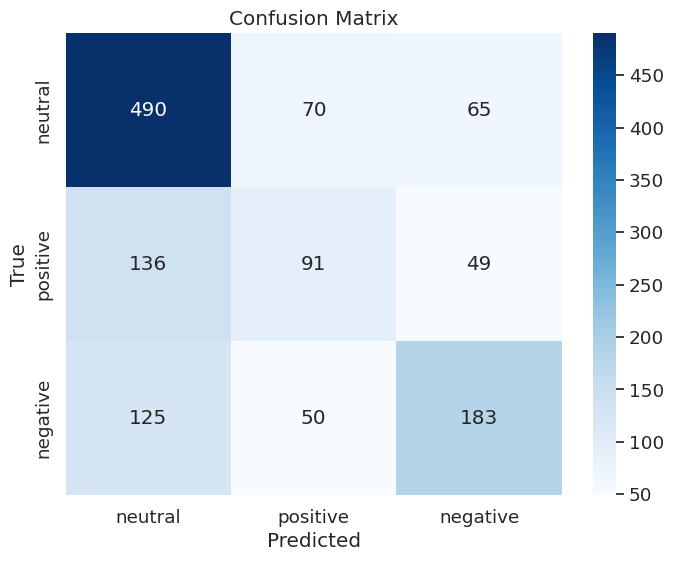

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Fungsi untuk menghitung dan mencetak akurasi, presisi, recall, dan F1-score
def evaluate_model(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    classification_rep = classification_report(true_labels, predicted_labels, target_names=['neutral', 'positive', 'negative'])

    print("Accuracy: {:.4f}".format(accuracy))
    print("Classification Report:\n", classification_rep)

    return classification_rep

# Fungsi untuk membuat dan menampilkan confusion matrix heatmap
def plot_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    labels = ['neutral', 'positive', 'negative']

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Menghitung prediksi pada data uji
test_input = torch.tensor(test_input).to(device)
test_mask = torch.tensor(test_mask).to(device)

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    prediction.append(logits)
    true_labels.append(label_ids)

flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Menampilkan hasil evaluasi
classification_report = evaluate_model(flat_true_labels, flat_prediction)

# Menampilkan confusion matrix heatmap
plot_confusion_matrix(flat_true_labels, flat_prediction)